## Setup

In [168]:
%load_ext autoreload
%autoreload 2

import os
from tqdm import tqdm
import numpy as np

# Torch modules
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch import amp

# Custom modules
from segmentation.utils import preprocessing, model_utils, traininglog
from segmentation.s3_utils import *
from segmentation.dataset import PointDataset
from models.unet_model import UNET
from segmentation.show import *
from segmentation.constants import VisualisationConstants
from segmentation.metrics import *


# Setting the device 
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
# Defining some constants that will be used throughout the notebook
DATA_DIR = 'Dataset/'
x_test_dir = os.path.join(DATA_DIR, 'Test/color')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')
x_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/color')
y_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/label')

# Splitting into training and validation
# Getting a list of relative paths to the images (x) and the masks/labels (y)
x_test_fps, y_test_fps = preprocessing.get_testing_paths(x_test_dir, y_test_dir)

# Splitting relative path names into into training and validation
x_train_fps, x_val_fps, y_train_fps, y_val_fps = preprocessing.train_val_split(x_trainVal_dir, y_trainVal_dir, 0.2)

In [170]:
# Creating the dataset
train_augmentation = preprocessing.get_training_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
val_augmentation = preprocessing.get_validation_augmentation()

train_dataset = PointDataset(x_train_fps[:10], y_train_fps[:10], augmentation=train_augmentation, preprocessing=preprocessing_fn)
val_dataset  = PointDataset(x_val_fps[:10], y_val_fps[:10], augmentation=val_augmentation, preprocessing=preprocessing_fn)

train_loader = DataLoader(train_dataset,batch_size= 2,num_workers=4,pin_memory=True,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size= 2,num_workers=4,pin_memory=True,shuffle=False)


In [ ]:
class Trainer:
    def __init__(self, model, optimizer, loss_fn, train_loader, valid_loader, experiment_name,
                 num_epochs, num_classes = 3, device = 'mps'):
        """
        Initialize the Trainer.
        
        Args:
            model: The PyTorch model.
            optimizer: The optimizer for training.
            loss_fn: The loss function.
            train_loader: DataLoader for training.
            valid_loader: DataLoader for validation.
            num_epochs (int): Total number of epochs to train.
            checkpoint_name (str): File name for saving checkpoints.
            training_log_name (str): File name for logging training.
            device: Torch device (e.g., 'cuda' or 'cpu').
        """
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.num_epochs = num_epochs
        self.device = device
        self.experiment_name = experiment_name
        self.scaler = amp.GradScaler()
        self.num_classes = num_classes

        # Initialise the metrics
        self.iou_metric = IOU(classes = [0, 1]) # clicked not clicked
        self.dice_metric = Dice(classes= [0, 1]) # clicked not clicked
        self.accuracy_metric = Accuracy(ignore_class=255) # ignore the border

        # Running trackers for some of the metrics
        self.mean_iou = 0
        self.dice = 0
        self.accuracy = 0

        # Setting the starting 'best' values for the metrics        
        self.best_mean_iou = 0
        self.best_accuracy = 0
        self.best_dice = 0
        self.best_val_loss = float('inf')
        

        self.start_epoch = 1

        self.checkpoint_name = 'checkpoint.pth'
        self.training_log_name = 'training_log.csv'

    def download_expirement(self):
        download_from_s3(f's3://computer-vision-state-dictionaries/{self.experiment_name}/{self.checkpoint_name}')
        download_from_s3(f's3://computer-vision-state-dictionaries/{self.experiment_name}/{self.training_log_name}')

    def load_checkpoint(self):
        checkpoint = model_utils.return_checkpoint_from(self.checkpoint_name)
        self.start_epoch = checkpoint['epoch'] + 1
        self.epoch = checkpoint['epoch']
        self.model.load_state_dict(checkpoint['state_dict'])

        # Loading validation attributes
        self.best_mean_iou = checkpoint['best_mean_iou']
        self.best_val_loss = checkpoint['best_val_loss']
        self.best_accuracy = checkpoint['best_accuracy']
        self.best_dice     = checkpoint['best_dice']

        self.val_loss_epoc = checkpoint['val_loss']
        self.mean_iou      = checkpoint['mean_iou']
        self.dice          = checkpoint['dice']
        self.accuracy      = checkpoint['accuracy']

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        loop = tqdm(self.train_loader, desc="Training")
        for batch_idx, (data, targets) in enumerate(loop):
            data = data.to(device=self.device, dtype=torch.float32)
            targets = targets.long().unsqueeze(1).to(device=self.device)
            
            with amp.autocast(device_type=self.device, dtype=torch.float16):
                # Squeeze targets to shape (N, H, W)
                targets = targets.squeeze(1)
                predictions = self.model(data)
                loss = self.loss_fn(predictions, targets)
            
            self.optimizer.zero_grad()
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            
            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        
        self.avg_loss_epoc = running_loss / len(self.train_loader)

    def validate_epoch(self):
        self.model.eval()
        
        # Reset the metrics for a fresh start
        total_loss = 0.0
        self.iou_metric.reset()
        self.dice_metric.reset()
        self.accuracy_metric.reset()
        
        with torch.no_grad():
            for data, targets in self.valid_loader:
                data = data.to(device=self.device, dtype=torch.float32)
                # Ensure targets have shape (N, H, W)
                targets = targets.long().unsqueeze(1).to(device=self.device)
                
                with amp.autocast(device_type=self.device, dtype=torch.float16):
                    predictions = self.model(data)
                    loss = self.loss_fn(predictions, targets.squeeze(1))
                
                total_loss += loss.item()
                
                # Convert logits to class predictions for IoU
                pred_masks = torch.argmax(predictions, dim=1)  # shape: (N, H, W)

                # Update the metric; targets are squeezed to (N, H, W)
                self.iou_metric.update(pred_masks, targets.squeeze(1))
                self.dice_metric.update(pred_masks, targets.squeeze(1))
                self.accuracy_metric.update(pred_masks, targets.squeeze(1))

        
        self.val_loss_epoc = total_loss / len(self.valid_loader)
        self.mean_iou = self.iou_metric.compute()
        self.accuracy = self.accuracy_metric.compute()
        self.dice = self.dice_metric.compute()

    def print_epoch_results(self):
         print(
            f"Epoch {self.epoch} | "
            f"train loss {self.avg_loss_epoc:.4f} | "
            f"val loss {self.val_loss_epoc:.4f} | "
            f"mean iou: {self.mean_iou:.4f} | "
            f"dice: {self.dice:.4f} | "
            f"accuracy: {self.accuracy:.4f}"
        )

    def checkpoint(self):
        return {
            'state_dict': self.model.state_dict(),
            'epoch': self.epoch,
            'mean_iou': self.mean_iou,
            'val_loss': self.val_loss_epoc,
            'dice': self.dice,
            'accuracy': self.accuracy,
            'best_val_loss': self.best_val_loss,
            'best_mean_iou': self.best_mean_iou,
            'best_dice': self.best_dice,
            'best_accuracy': self.best_accuracy
            }

    def update_best(self):
        if self.mean_iou > self.best_mean_iou:
            # Saving the the best model
            model_utils.save_checkpoint(self.checkpoint(),'best_model.pth')

            # Updading the best_val_loss and best_mean_iou
            self.best_val_loss = min(self.best_val_loss, self.val_loss_epoc)
            self.best_mean_iou = max(self.best_mean_iou, self.mean_iou)

    def backup_to_cloud(self):
            upload_file_to_s3(self.training_log_name, f's3://computer-vision-state-dictionaries/{self.experiment_name}')
            upload_file_to_s3(self.checkpoint_name, f's3://computer-vision-state-dictionaries/{self.experiment_name}')
            upload_file_to_s3(self.training_log_name, f's3://computer-vision-state-dictionaries/{self.experiment_name}')

    def update_training_log(self):
        # Logging the training
        traininglog.log_training(
            log_filename=self.training_log_name,
            epoch=self.epoch,
            train_loss=self.avg_loss_epoc,
            val_loss=self.val_loss_epoc,
            mean_iou = self.mean_iou
        )

    def train(self):
        last_epoch = self.num_epochs + self.start_epoch - 1
        for epoch in range(self.start_epoch, last_epoch + 1):
            self.epoch = epoch
            # train and validate for one epoc
            self.train_epoch()
            self.validate_epoch()
            # Printing progress
            self.print_epoch_results()
            # Update the training log
            self.update_training_log()
            # Save checkpoint if validation loss improves.
            self.update_best()
            # Optionally upload files every 10 epochs (if using something like Colab)
            if (epoch % 30 == 0) or (epoch == last_epoch):
                # Save the checkpoint every few epochs
                model_utils.save_checkpoint(self.checkpoint(), self.checkpoint_name)
                # upload the checkpoint to s3
                self.backup_to_cloud()
        
        print("Training complete.")

In [174]:
model = UNET(in_channels=4, out_channels=2).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
#dice_loss = smp.losses.DiceLoss(mode='binary', smooth=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
expirement_nunber = 0
experiment_name = f'unet_point_experiment_{expirement_nunber}'

point_unet_trainer = Trainer(model, optimizer, loss_fn, train_loader, val_loader, experiment_name, 2, 2)
point_unet_trainer.train()



/opt/miniconda3/envs/cv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:24<00:00,  4.99s/it, loss=0.701]


Epoch 1 |                 train loss 0.7462 |                 val loss 0.6966 |                 mean iou: 0.1880 |                 dice: 0.2801 |                 accuracy: 0.3670
=> Final model and metadata saved to best_model.pth


Training: 100%|██████████| 5/5 [00:19<00:00,  3.98s/it, loss=0.72] 


KeyboardInterrupt: 

In [14]:
point_unet_trainer.num_classes

2

In [28]:
point_unet_trainer.mean_iou

0.26726600527763367

In [32]:
point_unet_trainer.load_checkpoint()

=> Fetching checkpoint from checkpoint.pth


In [3]:
import pandas as pd
df = pd.read_csv('/Users/georgeboutselis/Downloads/training_log-4.csv')
import matplotlib.pyplot as plt

<Axes: xlabel='epoch'>

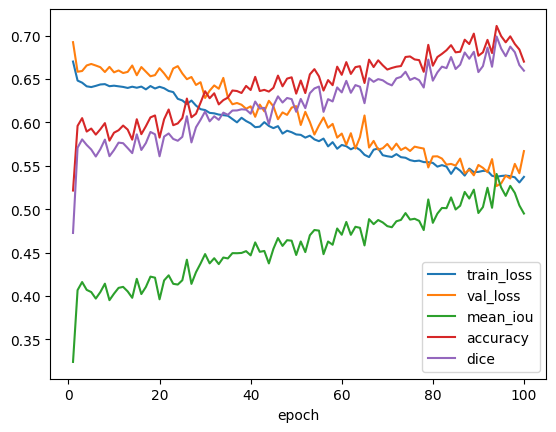

In [4]:
df.set_index('epoch').plot()